In [1]:
!pip install imbalanced-learn
!pip install xgboost
!pip install --upgrade numexpr

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load the dataset
file_path = 'End_dataframe.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Features and target
X = data[['Gender', 'Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]
y = data['VVR_Encoded']  # Assuming 'VVR_Encoded' is the target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost model and parameter grid for Grid Search
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [400, 600, 800],  
    'max_depth': [6, 9],  
    'learning_rate': [0.01, 0.1],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'reg_lambda': [1, 10],
}

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train_resampled.drop(columns='Gender'), y_train_resampled)

# Best model from Grid Search
best_xgb = grid_search.best_estimator_

# Make predictions on the test set and training set
y_pred_test = best_xgb.predict(X_test.drop(columns='Gender'))
y_pred_train = best_xgb.predict(X_train_resampled.drop(columns='Gender'))

# Evaluate the model on the test set
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

print("\nTest Set Performance:")
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Additional metrics for the test set
mcc_test = matthews_corrcoef(y_test, y_pred_test)
print(f"MCC (Test): {mcc_test:.2f}")

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print("\nConfusion Matrix (Training Set):")
print(confusion_matrix(y_train_resampled, y_pred_train))
print("\nClassification Report (Training Set):")
print(classification_report(y_train_resampled, y_pred_train))


mcc_train = matthews_corrcoef(y_train_resampled, y_pred_train)
print(f"MCC (Train): {mcc_train:.2f}")

# Gender-wise analysis for test set
class_labels = {0: 'Low_VVR', 1: 'High_VVR'}
gender_labels = {1: 'Male', 2: 'Female'}

X_test['y_test'] = y_test  # Add true labels for easy grouping
X_test['y_pred'] = y_pred_test  # Add predictions

print("\nTest Set Performance by Gender:")
test_gender_groups = X_test.groupby('Gender')
for gender, group in test_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_test']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")

# Gender-wise analysis for training set
print("\nTraining Set Performance by Gender:")
X_train_resampled['y_train'] = y_train_resampled  # Add true labels
X_train_resampled['y_pred'] = y_pred_train  # Add predictions

train_gender_groups = X_train_resampled.groupby('Gender')
for gender, group in train_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_train']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")



Best Parameters from Grid Search:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 800, 'reg_lambda': 1, 'subsample': 0.8}

Test Set Performance:

Confusion Matrix (Test Set):
[[69 23]
 [23 14]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        92
           1       0.38      0.38      0.38        37

    accuracy                           0.64       129
   macro avg       0.56      0.56      0.56       129
weighted avg       0.64      0.64      0.64       129

MCC (Test): 0.13

Training Set Performance:

Confusion Matrix (Training Set):
[[364   0]
 [  0 364]]

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00       364

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728


In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

# Ensure only the original features are used for predictions
X_train_resampled_features = X_train_resampled.drop(columns=['Gender', 'y_train', 'y_pred'], errors='ignore')

# Evaluate performance on the training set
y_train_pred = best_xgb.predict(X_train_resampled_features)  # Predictions on the training set
y_train_pred_prob = best_xgb.predict_proba(X_train_resampled_features)  # Probabilities for each class

# Overall PR-AUC for High VVR and Low VVR
pr_auc_low = average_precision_score(1 - y_train_resampled, y_train_pred_prob[:, 0])
pr_auc_high = average_precision_score(y_train_resampled, y_train_pred_prob[:, 1])

# Gender-wise analysis
gender_labels = {1: 'Male', 2: 'Female'}
X_train_resampled['Gender'] = X_train_resampled['Gender']  # Ensure Gender column exists
gender_groups = X_train_resampled.groupby('Gender')

pr_auc_by_gender = {}

for gender, group in gender_groups:
    gender_name = gender_labels.get(gender, gender)
    gender_indices = group.index
    y_train_gender = y_train_resampled[gender_indices]
    y_pred_prob_gender = y_train_pred_prob[gender_indices]
    
    # Calculate PR-AUC for Low VVR and High VVR for this gender
    pr_auc_low_gender = average_precision_score(1 - y_train_gender, y_pred_prob_gender[:, 0])
    pr_auc_high_gender = average_precision_score(y_train_gender, y_pred_prob_gender[:, 1])
    
    pr_auc_by_gender[gender_name] = {"Low_VVR": pr_auc_low_gender, "High_VVR": pr_auc_high_gender}

# Display training set performance
print("Training Set Performance:")

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_train_resampled, y_train_pred))

print("\nClassification Report:")
print(classification_report(y_train_resampled, y_train_pred, target_names=['Low VVR', 'High VVR']))

# Overall PR-AUC values
print(f"\nOverall PR-AUC Train (Low VVR): {pr_auc_low:.2f}")
print(f"Overall PR-AUC Train (High VVR): {pr_auc_high:.2f}")

# Print gender-specific PR-AUC values
print("\nPR-AUC Train by Gender:")
for gender_name, metrics in pr_auc_by_gender.items():
    print(f"{gender_name} - Low VVR PR-AUC: {metrics['Low_VVR']:.2f}")
    print(f"{gender_name} - High VVR PR-AUC: {metrics['High_VVR']:.2f}")




Training Set Performance:

Confusion Matrix:
[[364   0]
 [  0 364]]

Classification Report:
              precision    recall  f1-score   support

     Low VVR       1.00      1.00      1.00       364
    High VVR       1.00      1.00      1.00       364

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728


Overall PR-AUC Train (Low VVR): 1.00
Overall PR-AUC Train (High VVR): 1.00

PR-AUC Train by Gender:
Male - Low VVR PR-AUC: 1.00
Male - High VVR PR-AUC: 1.00
Female - Low VVR PR-AUC: 1.00
Female - High VVR PR-AUC: 1.00


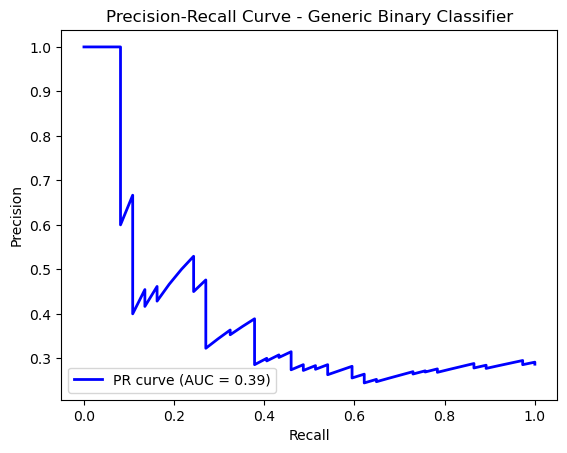

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure only the original features are used
X_test_features = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best model (generic binary classifier)
y_pred_prob = best_xgb.predict_proba(X_test_features)[:, 1]  # Probability of positive class (e.g., High VVR)

# Compute PR-AUC and Precision-Recall curve for the entire test set
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})', lw=2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Generic Binary Classifier')
plt.legend(loc="lower left")
plt.show()

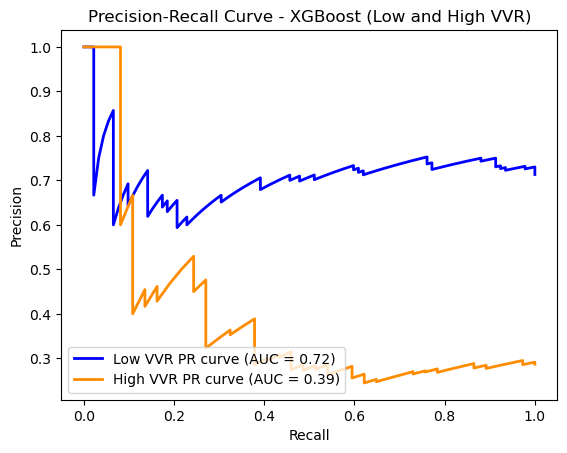

PR-AUC (Low VVR): 0.72
PR-AUC (High VVR): 0.39


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure only the original features are used
X_test_features = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best XGBoost model
y_pred_prob = best_xgb.predict_proba(X_test_features)  # Probabilities for both classes
y_pred_prob_low = y_pred_prob[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high = y_pred_prob[:, 1]  # Probability of High VVR (class 1)

# Compute PR-AUC and Precision-Recall curves for Low and High VVR
precision_low, recall_low, _ = precision_recall_curve(1 - y_test, y_pred_prob_low)  # For Low VVR
pr_auc_low = average_precision_score(1 - y_test, y_pred_prob_low)

precision_high, recall_high, _ = precision_recall_curve(y_test, y_pred_prob_high)  # For High VVR
pr_auc_high = average_precision_score(y_test, y_pred_prob_high)

# Plot Precision-Recall Curves
plt.figure()
plt.plot(recall_low, precision_low, label=f'Low VVR PR curve (AUC = {pr_auc_low:.2f})', lw=2, color='blue')
plt.plot(recall_high, precision_high, label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})', lw=2, color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()

# Print PR-AUC values
print(f"PR-AUC (Low VVR): {pr_auc_low:.2f}")
print(f"PR-AUC (High VVR): {pr_auc_high:.2f}")


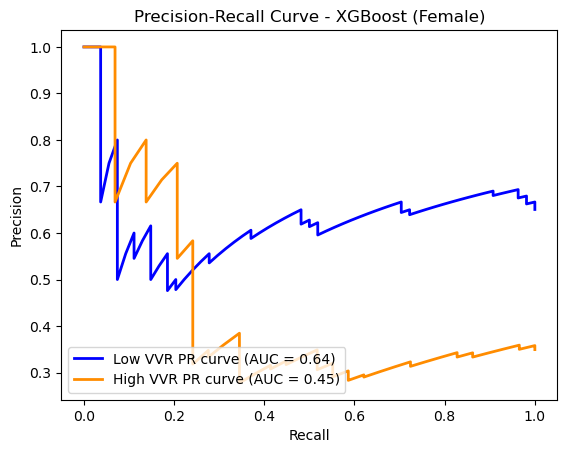

PR-AUC (Female - Low VVR): 0.64
PR-AUC (Female - High VVR): 0.45


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure only the original features used during training are passed
X_test_features = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best XGBoost model
y_pred_prob = best_xgb.predict_proba(X_test_features)  # Probabilities for both classes

# Filter data for Female
female_mask = X_test['Gender'] == 2
y_test_female = y_test[female_mask]
y_pred_prob_female = y_pred_prob[female_mask]
y_pred_prob_low_female = y_pred_prob_female[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high_female = y_pred_prob_female[:, 1]  # Probability of High VVR (class 1)

# Compute PR-AUC and Precision-Recall curves for Low and High VVR for Female
precision_low_female, recall_low_female, _ = precision_recall_curve(1 - y_test_female, y_pred_prob_low_female)  # Low VVR
pr_auc_low_female = average_precision_score(1 - y_test_female, y_pred_prob_low_female)

precision_high_female, recall_high_female, _ = precision_recall_curve(y_test_female, y_pred_prob_high_female)  # High VVR
pr_auc_high_female = average_precision_score(y_test_female, y_pred_prob_high_female)

# Plot Precision-Recall Curves for Female
plt.figure()
plt.plot(recall_low_female, precision_low_female, label=f'Low VVR PR curve (AUC = {pr_auc_low_female:.2f})', lw=2, color='blue')
plt.plot(recall_high_female, precision_high_female, label=f'High VVR PR curve (AUC = {pr_auc_high_female:.2f})', lw=2, color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Female)')
plt.legend(loc="lower left")
plt.show()

# Print PR-AUC values for Female
print(f"PR-AUC (Female - Low VVR): {pr_auc_low_female:.2f}")
print(f"PR-AUC (Female - High VVR): {pr_auc_high_female:.2f}")



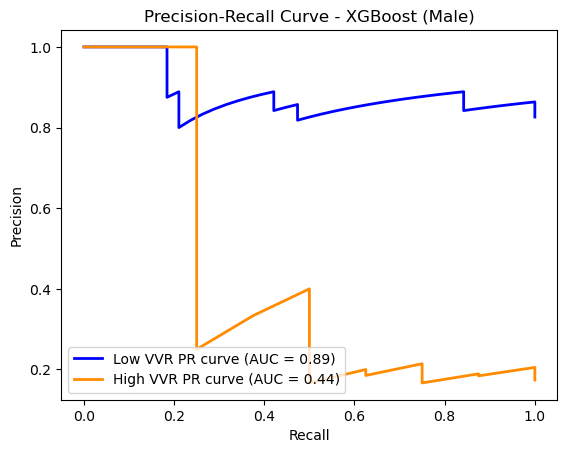

PR-AUC (Male - Low VVR): 0.89
PR-AUC (Male - High VVR): 0.44


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure only the original features used during training are passed
X_test_features = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best XGBoost model
y_pred_prob = best_xgb.predict_proba(X_test_features)  # Probabilities for both classes

# Filter data for Male
male_mask = X_test['Gender'] == 1
y_test_male = y_test[male_mask]
y_pred_prob_male = y_pred_prob[male_mask]
y_pred_prob_low_male = y_pred_prob_male[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high_male = y_pred_prob_male[:, 1]  # Probability of High VVR (class 1)

# Compute PR-AUC and Precision-Recall curves for Low and High VVR for Male
precision_low_male, recall_low_male, _ = precision_recall_curve(1 - y_test_male, y_pred_prob_low_male)  # Low VVR
pr_auc_low_male = average_precision_score(1 - y_test_male, y_pred_prob_low_male)

precision_high_male, recall_high_male, _ = precision_recall_curve(y_test_male, y_pred_prob_high_male)  # High VVR
pr_auc_high_male = average_precision_score(y_test_male, y_pred_prob_high_male)

# Plot Precision-Recall Curves for Male
plt.figure()
plt.plot(recall_low_male, precision_low_male, label=f'Low VVR PR curve (AUC = {pr_auc_low_male:.2f})', lw=2, color='blue')
plt.plot(recall_high_male, precision_high_male, label=f'High VVR PR curve (AUC = {pr_auc_high_male:.2f})', lw=2, color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Male)')
plt.legend(loc="lower left")
plt.show()

# Print PR-AUC values for Male
print(f"PR-AUC (Male - Low VVR): {pr_auc_low_male:.2f}")
print(f"PR-AUC (Male - High VVR): {pr_auc_high_male:.2f}")



In [11]:
import pandas as pd

# Remove the 'Gender' column as it was excluded during training
X_filtered = X_train_resampled[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Get feature importances from the trained XGBoost model
feature_importances = best_xgb.feature_importances_

# Check for consistency between features and importances
if len(feature_importances) != len(X_filtered.columns):
    print("Mismatch between feature importance array and feature columns!")
    print(f"Length of feature_importances: {len(feature_importances)}")
    print(f"Number of columns in X_filtered: {len(X_filtered.columns)}")
    # Exiting to prevent further issues
    raise ValueError("Feature columns and importances do not match.")

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X_filtered.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances interactively
importance_df

,Feature,Importance
0,Prior_Donation,0.321881
5,below_nose_max,0.137046
1,Lcheek_max,0.119771
6,HRV_minmax,0.106827
3,nose_max,0.105559
2,Rcheek_max,0.104668
4,chin_max,0.104248


Confusion Matrix (Test Set):
[[69 23]
 [23 14]]


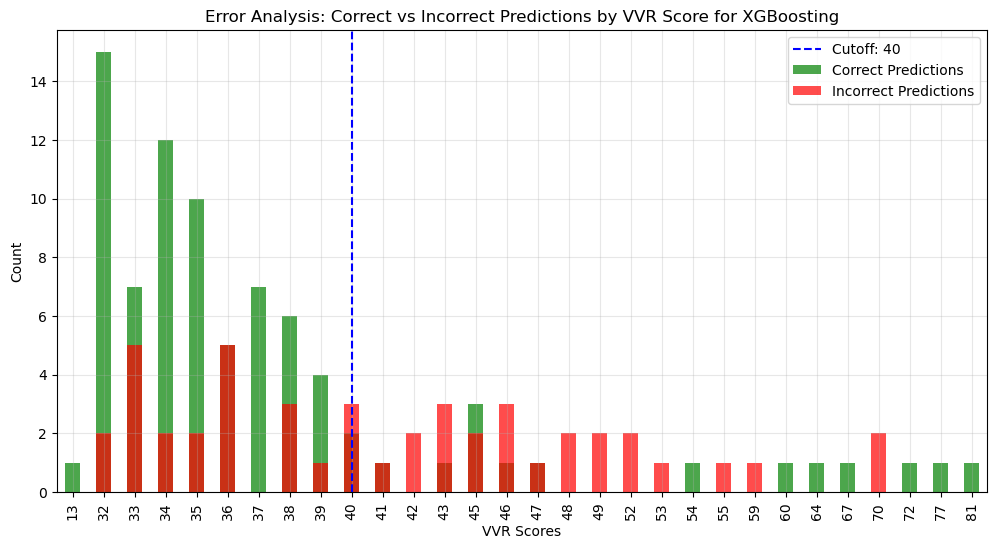

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = 'End_dataframe.csv' 
data = pd.read_csv(file_path)

# Features and target
X = data[['Gender', 'Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]
y = data['VVR_Encoded']  # Target variable
VVR_scores = data['VVR_sum'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_filtered = X_test.drop(columns=['Gender'])

# Predict with the trained XGBoost model
y_pred_test = best_xgb.predict(X_test_filtered)

# Add predictions and true labels to the test DataFrame
X_test['y_test'] = y_test
X_test['y_pred'] = y_pred_test
X_test['VVR_sum'] = VVR_scores[X_test.index]

# Validate confusion matrix alignment
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Set):")
print(conf_matrix)

# Error analysis: Identify correct and incorrect predictions
correct_predictions = X_test[X_test['y_test'] == X_test['y_pred']]
incorrect_predictions = X_test[X_test['y_test'] != X_test['y_pred']]

# Group data by VVR scores
correct_counts = correct_predictions['VVR_sum'].value_counts()
incorrect_counts = incorrect_predictions['VVR_sum'].value_counts()

# Merge for plotting
all_scores = pd.DataFrame({'Correct': correct_counts, 'Incorrect': incorrect_counts}).fillna(0)

# Plotting
plt.figure(figsize=(12, 6))
all_scores['Correct'].plot(kind='bar', color='green', label='Correct Predictions', alpha=0.7)
all_scores['Incorrect'].plot(kind='bar', color='red', label='Incorrect Predictions', alpha=0.7)

# vertical line at the cutoff 
cutoff = 40  
plt.axvline(x=all_scores.index.get_loc(cutoff), color='blue', linestyle='--', label=f'Cutoff: {cutoff}')

# Labels and title
plt.xlabel('VVR Scores')
plt.ylabel('Count')
plt.title('Error Analysis: Correct vs Incorrect Predictions by VVR Score for XGBoosting')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('error_analysis_vvr.pdf')
plt.show()
